# Take 2 of Generating Waveform for Inspiral of Eccentric BBH System 

Simona Miller, LIGO SURF Summer 2018
(Last updated: July 20, 2018)

In [1]:
import numpy as np
import scipy as sp
import pylab

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [2]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
# Define some constants: 
pi = np.pi
c = 2.99792458e8    # m/s
G = 6.67259e-11     # m^3/kg/s^2
Msun = 1.989e30     # kg

In [4]:
# Define initial coniditons: 

# LIGO detection band starts at GW frequency of 20Hz, aka orbital 
# frequency of 10 Hz, corresponding to an orbital period of 0.1 s
P0 = 0.3

# Initial eccentricity: 
e0 = 0.1
#e0 = 1e-10

# Masses (kg): 
m1 = 10*Msun
m2 = 10*Msun

# Reduced mass (kg): 
mu = float(m1*m2)/(m1+m2)

# Differential time step (in s): 
dt = 0.001

# Set distance to one megaparsec aka 3.086e22m: 
dist = 3.086e22

## Functions to Generate Time Series' for Eccentricity, Orbital Period, and Semimajor Axis

Eqns 11 and 12 from Luc Blanchet's *Gravitational Radiation from Post-Newtonian Sources and Inspiralling Compact Binaries*: 

$$
\dot{P}_{orb} = 
-\frac{192\pi}{5c^5} 
\bigg(\frac{2 \pi G} {P_{orb}}\bigg)^{5/3} 
\frac{m_1 m_2}{(m_1 + m_2)^{1/3}}
\bigg(1 + \frac{73}{24}e^2 + \frac{37}{96}e^4\bigg) 
\bigg(1-e^2\bigg)^{-7/2}
$$ 

$$
\dot{e} = 
-\frac{608\pi}{15c^5}
\frac{e}{P_{orb}}
\frac{m_1 m_2}{(m_1 + m_2)^{1/3}}
\bigg(1 + \frac{121}{304}e^2 \bigg) 
\bigg(1-e^2\bigg)^{-5/2}
$$

Kepler's Third Law: 

$$
a^3 =
{P_{orb}}^2 
\bigg(\frac{G (m_1+m_2)}{4\pi^2}\bigg)
$$

In [5]:
# Function to calculate first derivate of orbital period 
# from current orbital period and eccentricity using equation in 
# header 

# P = Orbital period (s), e = eccentricity (unitless), m1 and m2 = masses (kg)

# Returns dP/dt (s/s)

per_constant_num = -192*pi*((2*pi*G)**(5.0/3))
per_constant_denom = 5*(c**5)
per_constant = (per_constant_num/per_constant_denom)

def DerivativeOrbitalPeriod(P,e,m1,m2):
    
    term1 = P**(-5.0/3)
    term2 = m1*m2/((m1+m2)**(1.0/3))
    term3 = 1 + (73.0/24)*(e**2) + (37.0/96)*(e**4)
    term4 = (1-e**2)**(-7.0/2)
   
    dPdt = per_constant*term1*term2*term3*term4
        
    return dPdt

In [6]:
# Function to calculate first derivate of eccentricity
# from current orbital period and eccentricity using equation in 
# header 

# P = Orbital period (s), e = eccentricity (unitless), m1 and m2 = masses (kg)

# Returns de/dt (1/s)

ecc_constant_num = -608*pi*((2*pi*G)**(5.0/3))
ecc_constant_denom = 15*(c**5)
ecc_constant = (ecc_constant_num/ecc_constant_denom)

def DerivativeEccentricity(P,e,m1,m2):
    
    term1 = e/P
    term2 = P**(-5.0/3)
    term3 = m1*m2/((m1+m2)**(1.0/3))
    term4 = 1 + (121.0/304)*(e**2) 
    term5 = (1-e**2)**(-5.0/2)
    
    dedt = ecc_constant*term1*term2*term3*term4*term5
    
    return dedt

In [7]:
# Function to calculate semimajor axis at a given orbital period
# using Kepler's Third Law

# P = Orbital period (s), m1 and m2 = masses (kg)

# Returns semimajor axis distance (m)

def SemimajorAxis(P,m1,m2):
    
    a3 = (P**2)*G*(m1+m2)/(4*(pi**2))
    a = a3**(1.0/3)
    
    return a

In [8]:
# Function to create time series' for eccentricity, orbital period, and semimajor axis length

# P = Orbital period (s), e = eccentricity (unitless), m1 and m2 = masses (kg), 
# dt = differential time step (s)

def CreateTimeSeries(P0,e0,m1,m2,dt):
    
    a0 = SemimajorAxis(P0,m1,m2)
    
    # Setting initial values:
    t = 0  # s
    P = P0 # s
    e = e0 # unitless
    a = a0 # m
    
    # Creating time series:
    ts = [t]
    pts = [P]
    ets = [e]
    ats = [a0]
    
    numsteps = 0
    
    # Calculating final period - corresponding to ISCO 
    #Pf = np.sqrt(864)*pi*G*(m1+m2)/(np.power(c,3))
    
    # Stop at ISCO
    a_ISCO = 6*G*(m1+m2)/(c**2)
    
    while a > a_ISCO:
    #while a > 0:
        
        # Calculate change in orbital period in one differential time step
        #print "Period:", P
        dPdt = DerivativeOrbitalPeriod(P,e,m1,m2)
       
        # Calculate change in eccentricity in one differential time step
        #print "Eccentricity: ", e, "\n"
        dedt = DerivativeEccentricity(P,e,m1,m2)
            
        # Update values for orbtial and eccentricity and add values to time series 
        P = P + dPdt*dt
        e = e + dedt*dt
        
        if P <= 0 or e <= 0: 
            print "Error: negative or zero value value!"
            break
        pts.append(P)    
        ets.append(e)
            
        # Update value for semimajor axis and add to time series
        a = SemimajorAxis(P,m1,m2)
        ats.append(a)
        
        # Advance one time step
        t = t + dt 
        ts.append(t)
            
        numsteps = numsteps + 1
    
    print "Finished. Number of dt steps = ", numsteps, "\n"
    
    # Print some info: 
    print "Initial semimajor axis:", a0, "m"
    print "Semimajor axis at ISCO:", a_ISCO, "m\n"
    print "Initial eccentricity:", e0
    print "Eccentricity at ISCO:", ets[-1], "\n"
    print "Initial period:", P0, "s"
    print "Period at ISCO:", pts[-1], "s\n"
    
    return ts, ets, pts, ats

In [9]:
ts, ets, pts, ats = CreateTimeSeries(P0,e0,m1,m2,dt)

Finished. Number of dt steps =  107528 

Initial semimajor axis: 1822275.33644 m
Semimajor axis at ISCO: 177202.181292 m

Initial eccentricity: 0.1
Eccentricity at ISCO: 0.00252697955856 

Initial period: 0.3 s
Period at ISCO: 0.00904576106297 s



In [10]:
# ats: m --> km
ats_km = [float(a)/1000 for a in ats]

In [48]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(ts, ets)
plt.title("Eccentricity Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Eccentricity", fontsize=14)

plt.subplot(2,3,2)
plt.plot(ts, pts)
plt.title("Orbital Period Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Orbital Period (s)", fontsize=14)
plt.hlines(0.1, ts[0], ts[-1], colors='k', linestyles='dashed', label='LIGO band boundary')
plt.legend()

plt.subplot(2,3,3)
plt.plot(ts, ats_km)
plt.title("Semi-major Axis Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Semi-major Axis Length (km)", fontsize=14)

plt.subplot(2,3,4)
plt.plot(ets, pts, 'r')
plt.title("Orbital Period vs. Eccentricity", fontsize=16)
plt.xlabel("Eccentricity", fontsize=14)
plt.ylabel("Orbital Period (s)", fontsize=14)
plt.hlines(0.1, ets[0], ets[-1], colors='k', linestyles='dashed', label='LIGO band boundary')
plt.legend()

plt.subplot(2,3,5)
plt.plot(ets, ats_km, 'r')
plt.title("Semi-major Axis vs. Eccentricity", fontsize=16)
plt.xlabel("Eccentricity", fontsize=14)
plt.ylabel("Semi-major Axis Length (km)", fontsize=14)

plt.subplot(2,3,6)
plt.plot(ats_km, pts, 'r')
plt.title("Orbital Period vs. Semi-major Axis", fontsize=16)
plt.xlabel("Semimajor Axis Length (km)", fontsize=14)
plt.ylabel("Orbital Period (s)", fontsize=14)
plt.hlines(0.1, ats_km[0], ats_km[-1], colors='k', linestyles='dashed', label='LIGO band boundary')
plt.legend()

plt.subplots_adjust(hspace=.5)

## Energy and Angular Momentum

The Newtonian Mechanical definition of orbital energy $E_{orb}$ for an elliptical orbit is (in Joules): 

$$ E_{orb} = K + U = \frac{U}{2} = -\frac{G\,M_{tot}\,\mu}{2a} $$

The Newtonian Mechanical definition of orbital angular momentum $L_{orb}$ for an elliptical orbit is (in kg m^2/s) :

$$ L_{orb} = \sqrt{G\,M_{tot}\,\mu\,a\,(1\,-\,e^2)} $$

In [12]:
# Generating time series for ORBITAL ENERGY 

E_orb = []

for a in ats: 
    Eorb = -(G*m1*m2)/(2*a)
    E_orb.append(Eorb)

In [13]:
# Generating time series for ORBITAL ANGULAR MOMENTUM

L_orb = []

for i in range(len(ts)):
    
    a = ats[i]
    e = ets[i]
    
    Lorb = np.sqrt(G*(m1+m2)*(mu**2)*a*(1-e**2)) 
    
    L_orb.append(Lorb)

In [14]:
# Plotting Orb Energy and Angular Momentum 

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(ts, E_orb)
plt.title("Energy Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Energy (J)", fontsize=14)

plt.subplot(1,2,2)
plt.plot(ts, L_orb)
plt.title("Angular Momentum Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Angular momentum ($kg\,m^2 / s$)", fontsize=14)

Text(0,0.5,u'Angular momentum ($kg\\,m^2 / s$)')

## Converting everything to geometrized units and normalizing by total mass to make unitless

_Geometrized Units:_

** Length:** 1 m = 1 m 

**Mass**: 1 m = 1.3466e27 kg

**Time**: 1 m = 3.3356e-9 s

**Energy**: 1 m = 1.2102e44 J

**Angular Momentum**: 1 m$^2$ = 4.037e35 kg m$^2$ / s 

In [15]:
# Masses (kg): 
m1_geo = m1/1.3466e27 # kg -> m
m2_geo = m2/1.3466e27 # kg -> m

m_tot_geo = m1_geo + m2_geo # m

In [16]:
# Constants 

P0_geo = P0/(3.3356e-9*m_tot_geo) # s -> m -> m/m

mu_geo = mu/(1.3466e27*m_tot_geo) # kg -> m -> m/m

dt_geo = dt/(3.3356e-9*m_tot_geo) # s -> m -> m/m

dist_geo = dist/m_tot_geo # m -> m/m

In [17]:
print m1_geo, m2_geo, m_tot_geo, P0_geo, mu_geo, dt_geo, dist_geo

14770.5331947 14770.5331947 29541.0663894 3044.53605033 0.25 10.1484535011 1.04464746104e+18


In [18]:
# Transforming time series
# s -> m/m

t=0
ts_geo = [t] 

for i in range(len(ts)-1):
    t = t + dt_geo
    ts_geo.append(t)
    
print len(ts), len(ts_geo)

107529 107529


In [19]:
pts_geo = [p/(3.3356e-9*m_tot_geo) for p in pts] # s -> m -> m/m
ats_geo = [a/m_tot_geo for a in ats] # m -> m/m
E_orb_geo = [E/(1.2102e44*m_tot_geo) for E in E_orb] # J -> m -> m/m
L_orb_geo = [L/(4.037e35*(m_tot_geo)**2) for L in L_orb] # kgm^2/s -> m^2 -> m^2/m^2

In [20]:
# Plotting to check new units

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(ts, E_orb_geo)
plt.title("Energy Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Energy", fontsize=14)

plt.subplot(2,2,2)
plt.plot(ts, L_orb_geo)
plt.title("Angular Momentum Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Angular momentum", fontsize=14)

plt.subplot(2,2,3)
plt.plot(ts, ats_geo)
plt.title("Semimajor Axis Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Semimajor Axis", fontsize=14)

plt.subplot(2,2,4)
plt.plot(ts, pts_geo)
plt.title("Orbital Period Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Period", fontsize=14)

plt.subplots_adjust(hspace=.5)

## Specific Energy + Orbital Momentum 

$$ E = 1 + \frac{E_{orb}}{\mu} $$

$$ L = \frac{L_{orb}}{\mu} $$

where all terms are in geometrized units and made unitless by dividing my powers of total mass

In [21]:
Ets = [1+(E/mu_geo) for E in E_orb_geo]
Lts = [L/mu_geo for L in L_orb_geo]

Text(0,0.5,u'Angular momentum')

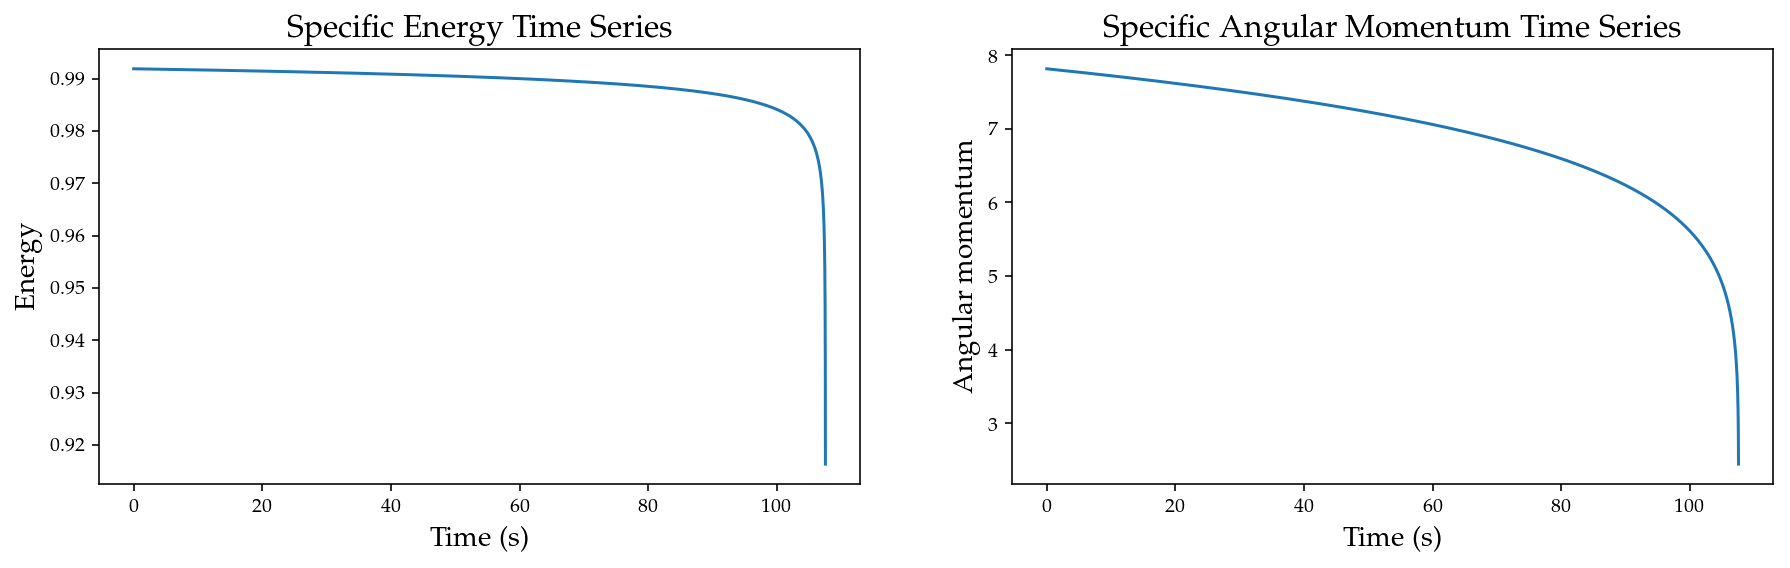

In [22]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(ts, Ets)
plt.title("Specific Energy Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Energy", fontsize=14)

plt.subplot(1,2,2)
plt.plot(ts, Lts)
plt.title("Specific Angular Momentum Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Angular momentum", fontsize=14)

##  True Anomaly ($\psi$) and Distance between BHs (r)

** Everything in geometrized units divided by total mass from here on out **

Rate of change of true anomaly:

$$
\dot{\psi}=
\frac{{(1\,-\,E^2)}^{1/2}}{V_t\,(1\,-\,e^2)}
{\bigg[
a\,(1-e^2)\,-C_0\,(1-e)\,-\,e\,a\,(1-e^2) - e\,C_0\,(1-e)\,cos(\psi)
\bigg]}^{1/2}
{\bigg[a\,(1-e^2)\,(1+e)
\bigg]}^{1/2}
$$

where $a$ is the semimajor axis length,  $e$ is eccentricity, and $C_0$ is:

$$
C_0 = \frac{2}{1-E^2} - 2a
$$

Potential $V_t$ is defined as:

$$
V_t = 
\frac{E\,r^4}{r^2\,-\,2r}
$$

Use true anomaly to find r, distance between the two BHs:
$$
r = 
\frac{a\,\big(1-e^2\big)}{1+e\,cos{\psi}}
$$

In [23]:
# Function to calculate distance between two BHs
# a = semimajor axis length, e = eccentricity, psi = true anomaly 

def Distance(a,e,psi): 
    
    num = a*(1-(e**2))
    denom = 1+e*np.cos(psi)
    
    r = float(num)/denom 
    
    return r

In [24]:
# Function to calculate derivative of true anomaly psi
# a = semimajor axis length, e = eccentricity, E = energy, 
# r = distance between BH, psi = true anomaly 

def DerivativePsi(a,e,E,r,psi): 
    
    C0 = 2.0/(1-E**2) - 2*a
    
    Vt = E*(r**4)/(r**2 - 2*r)
    
    term1 = np.sqrt(1-E**2)/(Vt*(1-e**2))
    term2 = np.sqrt(a*(1-e**2) - C0*(1-e) - e*a*(1-e**2) - e*C0*(1-e)*np.cos(psi))
    term3 = np.sqrt(a*(1-e**2)*(1+e))
    
    psidot = term1*term2*term3
    
    return psidot

In [25]:
# Function to create time series' for psi, psi dot, and r

# ats = time series for semi-major axis length, ets = time series for eccentricity
# psi0 = initial true anomaly, Ets = energy time series, dt = differential time step

def CreateTimeSeries2(ats, ets, psi0, Ets, dt):

    # Setting initial values:  
    psi = psi0
    r = r = Distance(ats[0], ets[0], psi0)
    dpsidt = dpsidt = DerivativePsi(ats[0],ets[0],Ets[0],r,psi0)
    
    # Creating time series:
    rts = [r]
    psits = [psi]
    psidot = [dpsidt]
        
    for i in range(1,len(ats)):
        
        a = ats[i]
        e = ets[i]
        E = Ets[i]
        
        # Update r
        r = Distance(a, e, psi)
        
        # Update psidot
        dpsidt = DerivativePsi(a,e,E,r,psi)
        
        # Update psi
        psi = psi + dpsidt*dt
        #psi = psi - dpsidt*dt
        
        # Add new values to time series'
        rts.append(r)
        psits.append(psi)
        psidot.append(dpsidt)
          
    return rts, psits, psidot

In [26]:
# Generating time series

psi0 = 0

rts, psits, psidot = CreateTimeSeries2(ats_geo, ets, psi0, Ets, dt_geo)

In [27]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(ts, rts)
plt.title("Distance Between BH Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("r", fontsize=14)

plt.subplot(2,1,2)
plt.plot(ts, psits)
plt.title("True Anamoly Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$\psi$", fontsize=14)

plt.subplots_adjust(hspace=.25)

## Orbital Angle ($\phi$) 

$$ \frac{d \phi}{dt} = \frac{d\phi}{d\tau} \frac{d\tau}{dt}$$

$$ \dot{\phi} = \frac{L}{r^2} \frac{r^2}{V_t} = \frac{L}{V_t} $$

where 
$$ V_t = \frac{E\,r^4}{r^2\,-\,2r} $$

In [28]:
phi0 = 0
theta = pi/4

In [29]:
# Function to calculate derivative of phi
# L = angular momentum, E = energy, r = distance, 
# mu = reduced mass, theta = inclination angle

def DerivativePhi(L,E,r):
    Vt = E*(r**4)/(r**2 - 2*r)
    return L/Vt

In [30]:
# Generating time series for phi and phidot 

# Set initial values
phi = phi0
dphidt = DerivativePhi(Lts[0],Ets[0],rts[0])

# Initialize time series
phits = [phi]
phidot = [dphidt]

for i in range(1,len(ts)):
    
    L = Lts[i]
    E = Ets[i]
    r = rts[i]
    
    # Update dphi/dt
    dphidt = DerivativePhi(L,E,r)
    
    # Update phi
    phi = phi + dphidt*dt_geo
    #phi = phi - dphidt*dt_geo
    
    phits.append(phi)
    phidot.append(dphidt)

Text(0,0.5,u'$\\phi$')

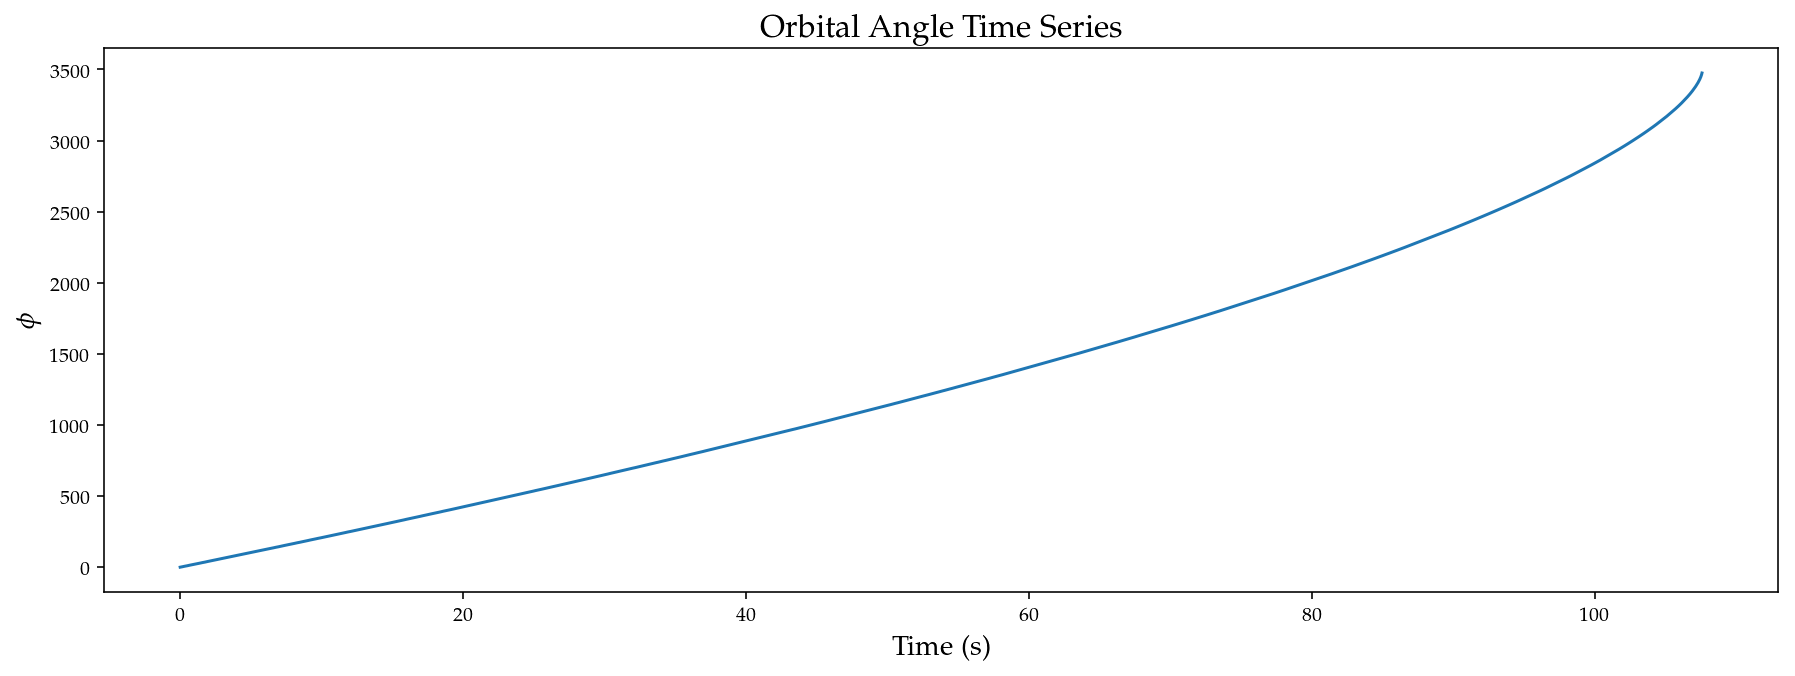

In [31]:
plt.figure(figsize=(15,5))
plt.plot(ts, phits)
plt.title("Orbital Angle Time Series", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$\phi$", fontsize=14)

## Finding $\ddot{\phi}$, $\dot{r}$, and $\ddot{r}$

In [32]:
%%capture output
%run Derivative_function.ipynb

RuntimeError: LaTeX was not able to process the following string:
'y = x^2'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(./b51e2f8f348f8e6c72b31394a26e8fc0.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file b51e2f8f348f8e6c72b31394a26e8fc0.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...ize{10.000000}{12.500000}{\rmfamily y = x^
                                                  2}
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omlzplm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omszplm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omxzplm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1zplm.fd)
! Extra }, or forgotten $.
l.12 ...e{10.000000}{12.500000}{\rmfamily y = x^2}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./b51e2f8f348f8e6c72b31394a26e8fc0.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on b51e2f8f348f8e6c72b31394a26e8fc0.dvi (1 page, 300 bytes).
Transcript written on b51e2f8f348f8e6c72b31394a26e8fc0.log.
 



In [33]:
phiddot = Derivative(phidot, ts_geo)
rdot = Derivative(rts, ts_geo)
rddot = Derivative(rdot, ts_geo[1:-1])

## Generating Waveform Using Quadrupole Formula

\begin{multline}
h_+(t) = \frac{\mu}{2\,D}
\Bigg(
\bigg[1\,-\,2\,cos\big(2\theta\big)\,cos\,^2\big(\phi(t)\big) - 3\,cos\big(2\,\phi(t)\big)\,\bigg]\dot{r}\,^2(t) \\
+ \bigg(3\,+\,cos\big(2\theta\big)\bigg)\bigg[2\,cos\big(2\,\phi(t)\big)\,\dot{\phi}\,^2(t) + \,sin\big(2\,\phi(t)\big)\,\ddot{\phi}(t)\,\bigg]r\,^2(t) \\
+ \bigg[4\,\bigg(3\,+\,cos\big(2\theta\big)\bigg)\,sin\big(2\,\phi(t)\big)\dot{\phi}(t)\dot{r}(t) \\
+ \bigg( 1\,-\,2\,cos\big(2\theta\big)\,cos\,^2\big(\phi(t)\big)\,-\,3\,cos\big(2\phi(t)\big)\bigg)\ddot{r}(t)
\bigg] r(t)
\Bigg)
\end{multline}

\begin{multline}
h_\times(t) = -\frac{2\,\mu\,cos(\theta)}{D}
\Bigg( sin\big(2\phi(t)\big)\,\dot{r}^2(t)
+ \bigg[cos\big(2\phi(t)\big)\,\ddot{\phi}(t)\,-\,2\,sin\big(2\phi(t)\big)\,\dot{\phi}^2(t) \bigg]r^2(t) \\
+ \bigg[4\,cos\big(2\phi(t)\big)\,\dot{\phi}(t)\,\dot{r}(t)\,+\,sin\big(2\phi(t)\big)\,\ddot{r}(t)\bigg]r(t)
\Bigg)
\end{multline}

In [34]:
# Function to generate GW h+ polarization of strain time series for eccentric BBH
# mu = reduced mass, D = distance to source, theta = incinlination angle
# phi, phidot, phiddot = orbital angle and its first and second derivatives 
# r, rdot, rddot = distance between BHs and its first and second derivatives

def hplus(mu,D,theta,phi,phidot,phiddot,r,rdot,rddot):
    
    cos_2phi = np.cos(2*phi)
    sin_2phi = np.sin(2*phi)
    cos_phi_sq = (np.cos(phi))**2
    cos_2theta = np.cos(2*theta)
    
    coeff = float(mu)/(2*D)
    
    term1 = (1 - 2*cos_2theta*cos_phi_sq - 3*cos_2phi)*(rdot**2)
    term2 = (3 + cos_2theta)*(2*cos_2phi*(phidot**2) + sin_2phi*phiddot)*(r**2)
    term3 = (4*(3 + cos_2theta)*sin_2phi*phidot*rdot + (1 - 2*cos_2theta*cos_phi_sq - 3*cos_2phi)*rddot)*r
    
    hp = coeff*(term1+term2+term3)
    
    return hp 

In [35]:
# Function to generate GW hx polarization of strain time series for eccentric BBH
# mu = reduced mass, D = distance to source, theta = incinlination angle
# phi, phidot, phiddot = orbital angle and its first and second derivatives 
# r, rdot, rddot = distance between BHs and its first and second derivatives

def hcross(mu,D,theta,phi,phidot,phiddot,r,rdot,rddot):
    
    cos_2phi = np.cos(2*phi)
    sin_2phi = np.sin(2*phi)
    
    coeff = 2.0*mu*np.cos(theta)/D
    
    term1 = sin_2phi*(rdot**2)
    term2 = (cos_2phi*phiddot - 2*sin_2phi*(phidot**2))*(r**2)
    term3 = (4*cos_2phi*phidot*rdot + sin_2phi*rddot)*r
    
    hc = coeff*(term1+term2+term3)
    
    return hc 

In [36]:
# Function that returns plus and cross modes for eccentric waveform
# mu = reduced mass, D = distance to source, theta = incinlination angle
# phi, phidot, phiddot = TIME SERIES for orbital angle and its first and second derivatives 
# r, rdot, rddot = TIME SERIES for distance between BHs and its first and second derivatives
# Note: all time series must be same length

def EccWaveform(mu,D,theta,phi,phidot,phiddot,r,rdot,rddot):
    
    hp = []
    hc = []
    
    for i in range(len(rddot)):       
        
        p = hplus(mu,D,theta,phi[i],phidot[i],phiddot[i],r[i],rdot[i],rddot[i])
        hp.append(p)
        
        c = hcross(mu,D,theta,phi[i],phidot[i],phiddot[i],r[i],rdot[i],rddot[i])
        hc.append(c)
    
    return hp, hc

Putting it all together ... 

In [37]:
# Checking lengths of time series: 

print len(phits), len(phidot), len(phiddot), len(rts), len(rdot), len(rddot), len(ts)

107529 107529 107527 107529 107527 107525 107529


In [38]:
print len(phits[2:-2]), len(phidot[2:-2]), len(phiddot[1:-1]), len(rts[2:-2]), len(rdot[1:-1]), len(rddot)

107525 107525 107525 107525 107525 107525


In [39]:
# Generating waveform!

hp, hc = EccWaveform(mu_geo, dist_geo, theta, phits[2:-2], phidot[2:-2], phiddot[1:-1], rts[2:-2], rdot[1:-1], rddot)

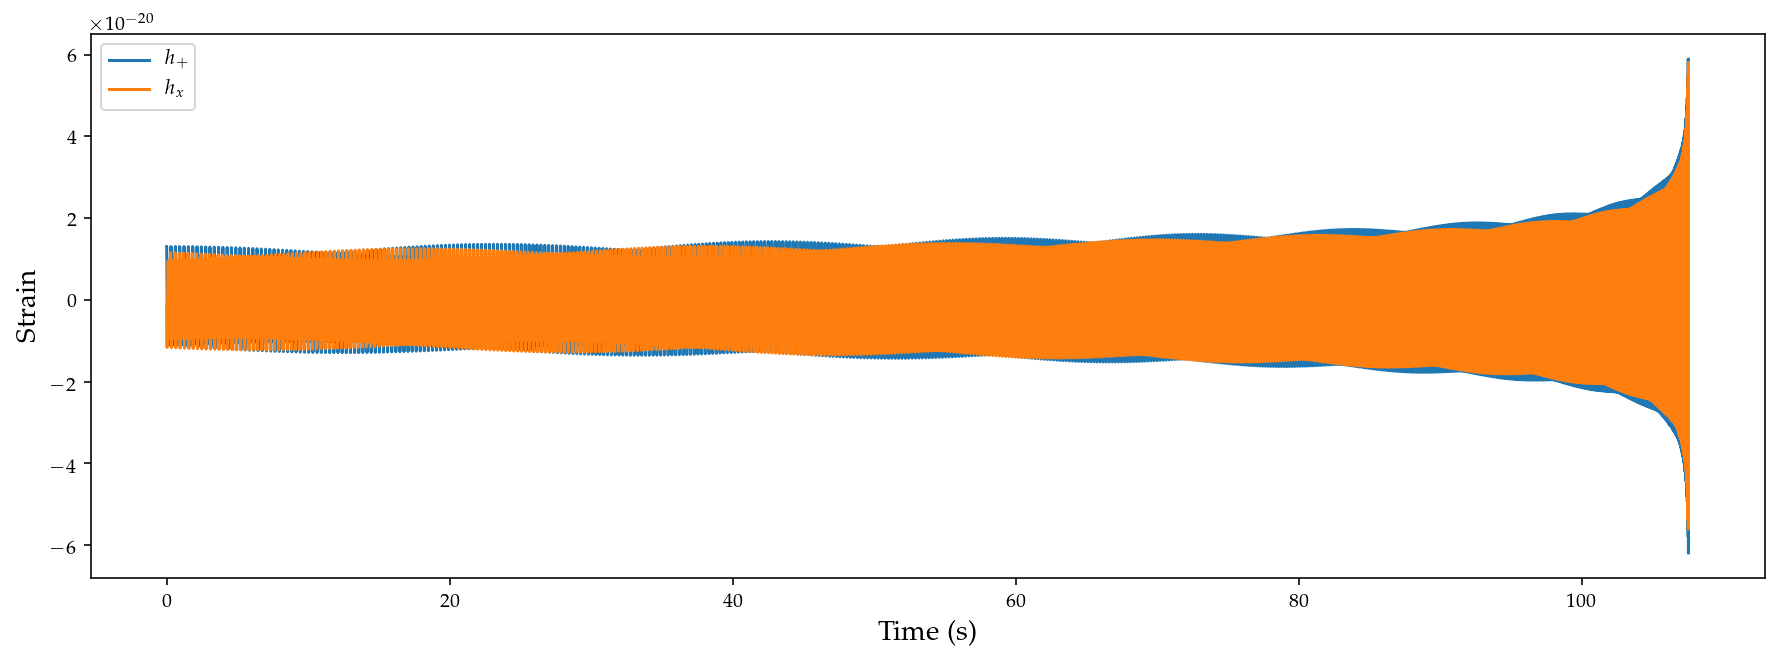

In [40]:
plt.figure(figsize=(15,5))
plt.plot(ts[2:-2], hp, label="$h_+$")
plt.plot(ts[2:-2], hc, label="$h_x$")
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Strain", fontsize=14)
plt.legend()

(106.02900000014222, 107.57800000014937)

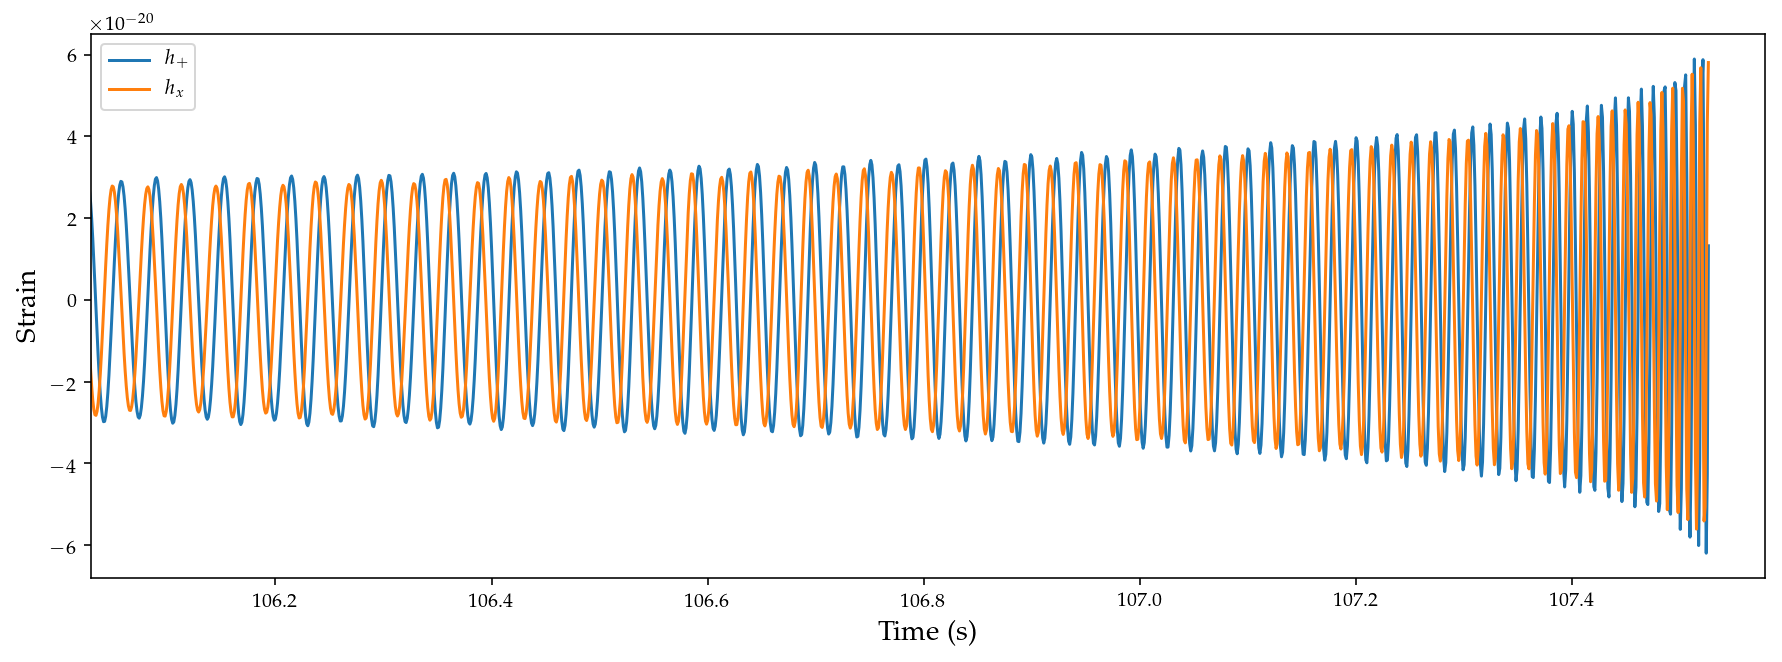

In [41]:
plt.figure(figsize=(15,5))
plt.plot(ts[2:-2], hp, label="$h_+$")
plt.plot(ts[2:-2], hc, label="$h_x$")
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Strain", fontsize=14)
plt.legend()
plt.xlim(ts[-1500], ts[-1]+0.05)

## Debugging

Text(0,0.5,u'$\\ddot{r}$')

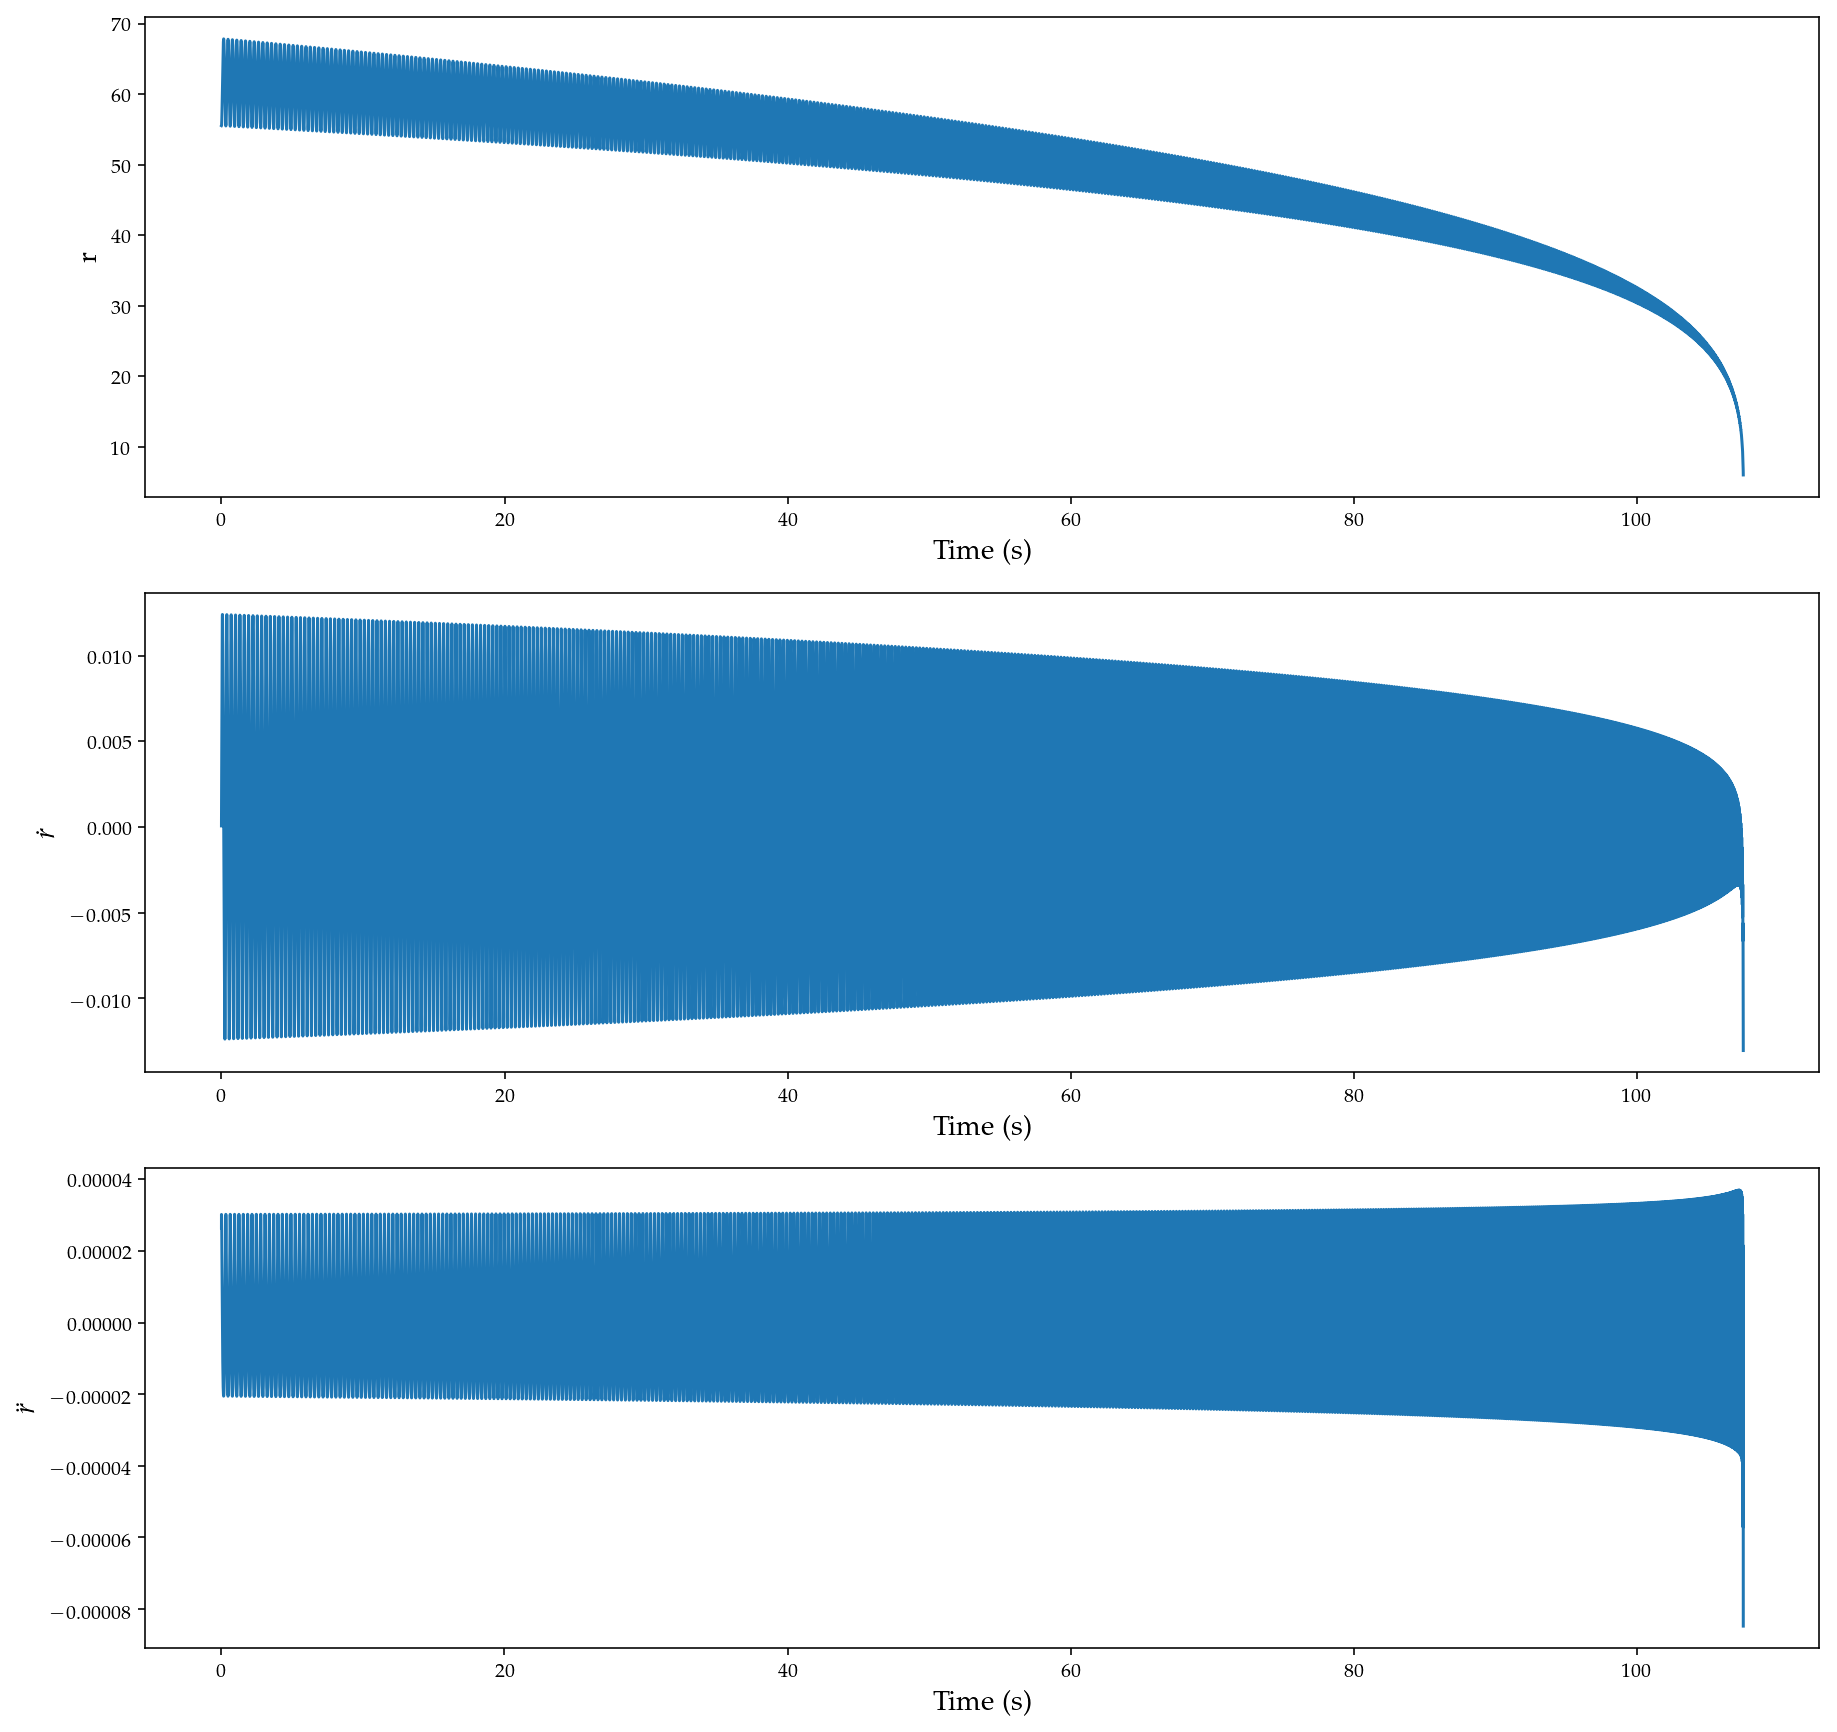

In [42]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.plot(ts, rts)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("r", fontsize=14)

plt.subplot(3,1,2)
plt.plot(ts[1:-1], rdot)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$\dot{r}$", fontsize=14)

plt.subplot(3,1,3)
plt.plot(ts[2:-2], rddot)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$\ddot{r}$", fontsize=14)

Text(0,0.5,u'$\\ddot{\\phi}$')

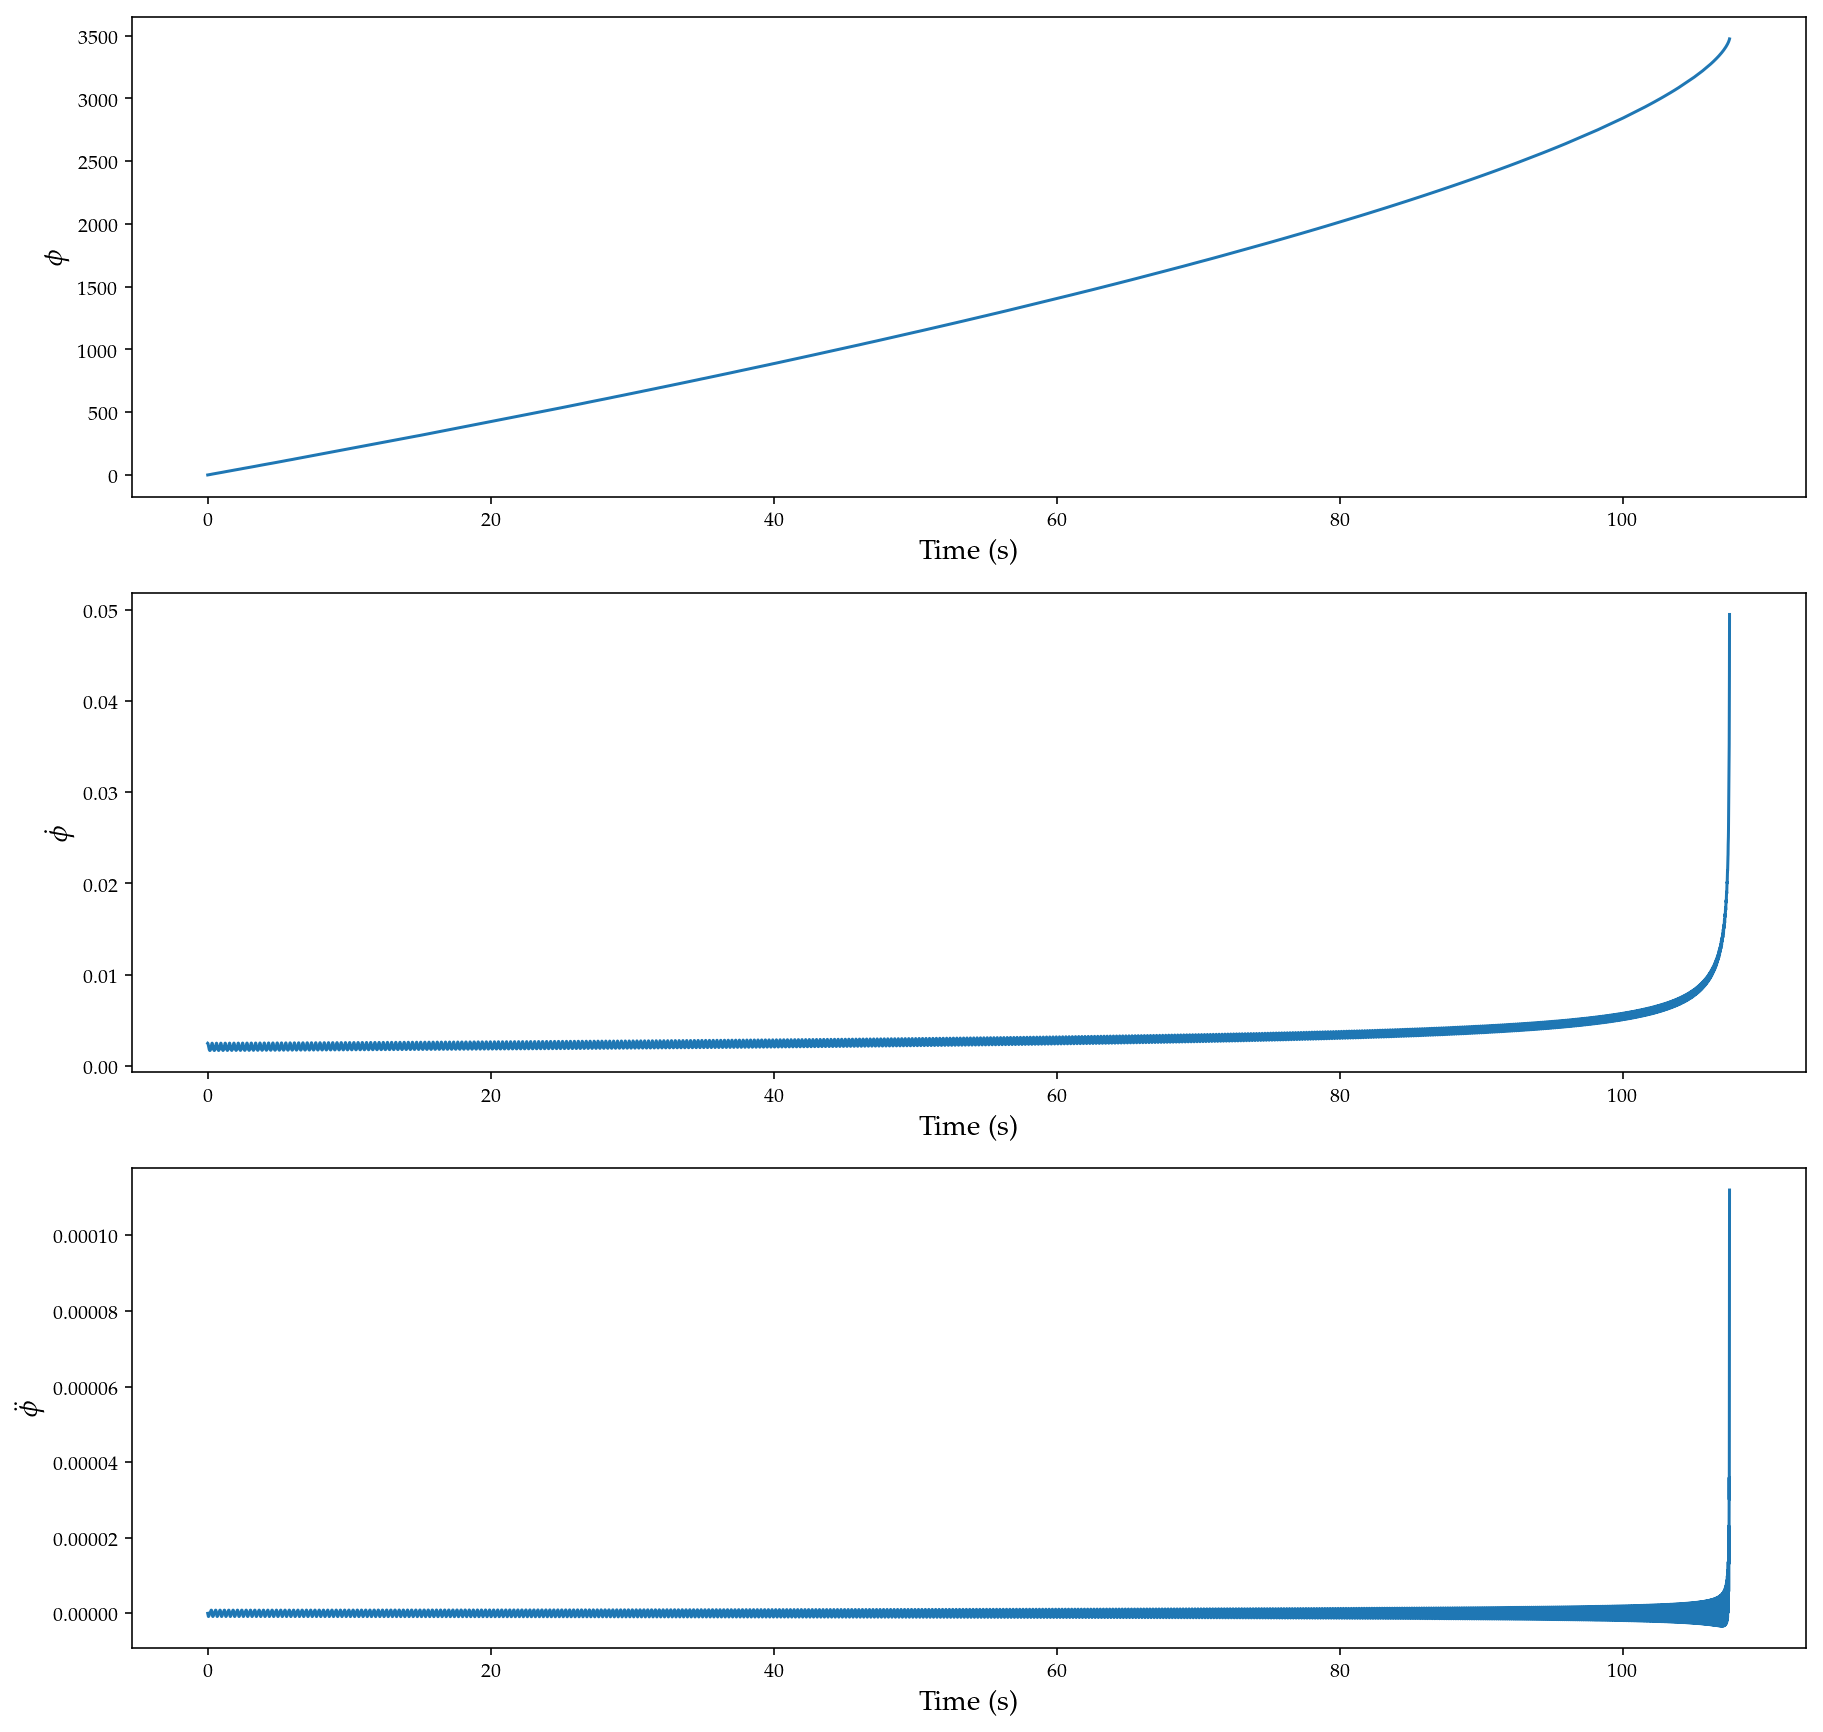

In [43]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.plot(ts, phits)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$\phi$", fontsize=14)

plt.subplot(3,1,2)
plt.plot(ts, phidot)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$\dot{\phi}$", fontsize=14)

plt.subplot(3,1,3)
plt.plot(ts[1:-1], phiddot)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$\ddot{\phi}$", fontsize=14)

In [44]:
Vt = []

for i in range(len(ts)):   
    V = (Ets[i]*(rts[i]**4)/(rts[i]**2 - 2*rts[i]))/(rts[i]**2)
    Vt.append(V)

Text(0,0.5,u'$V_t/r^2$')

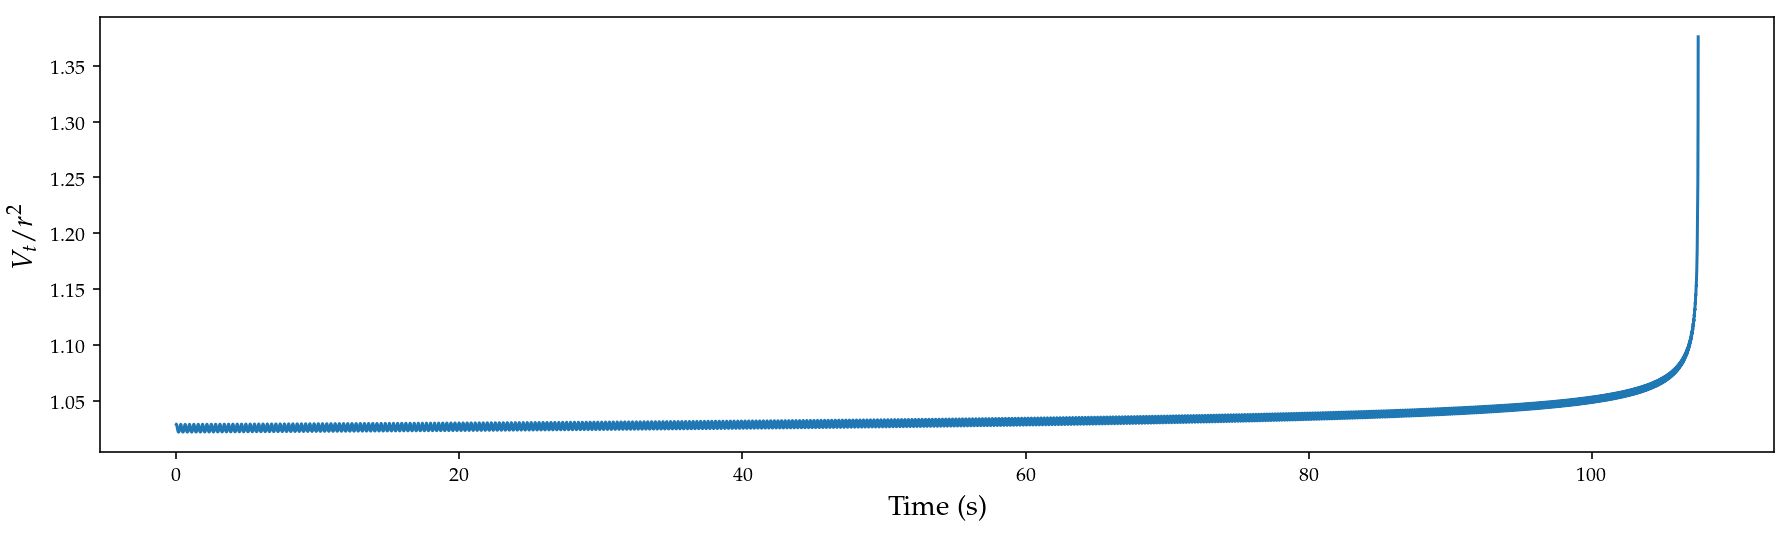

In [45]:
plt.figure(figsize=(15,4))
plt.plot(ts, Vt)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("$V_t/r^2$", fontsize=14)